In [ ]:
---
layout: post
title:  "The Value of DR High Frequency"
short_title: "DR-H Value"
desc: "Investigating the secondary value from charging via DR-H."
long_desc: "Investigating the secondary value from charging via DR-H."
date: ###DATE
categories: [tutorial]
tags: [plotting]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/drh"
---

In [154]:
# A bunch of imports to keep the plotting code minimal
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['hist.bins'] = 50
plt.rcParams['lines.markersize'] = 2
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["font.size"] = 14
plt.rcParams["axes.grid"] = False
plt.rcParams["image.cmap"] = "magma"
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),
    "savefig.facecolor": (0.0, 0.0, 0.0, 0.0),
})
from cycler import cycler	  
plt.rcParams['axes.prop_cycle'] = (cycler(color=['#009aeb', '#3df2e0', '#ff890d', '#ffd075', '#96e879']) + cycler(linestyle=['-', '--', ':', '-.', '-']))

In [145]:
from datetime import datetime as dt, timezone as tz
from arenkods.data.fs import FeatureStore
fs = FeatureStore(address="http://172.29.11.21:5903")
start = dt(2021, 10, 31, tzinfo=tz.utc)
end = dt(2022, 10, 31, tzinfo=tz.utc)
df = fs.get_latest_features(["dr_hf_power", "system_buy_price", "m7_gate_price_mean"], start, end)
df = df.rename(columns={"system_buy_price": "Imbalance Price", "m7_gate_price_mean": "M7 Price", "dr_hf_power": "DRH Power"})

In [146]:
from nimbus.utils import determine_efa
efas = determine_efa(df.index.to_series())
df["EFA"] = efas["efa"]

In [147]:
df.to_csv("data.csv.gz")

# How much is DR High actually worth?

With the new DR and DM markets, we now have more ancilliary services than ever that we can choose to participate in. For older frequency services, such as FFR, the value of participating in the service comes from the availability payment that's part of each month's tender.

The power that flows in - or out of - an asset in FFR isn't really a driver of the price, as the service comes with a response payment based upon the response energy. This effectively takes any overall import/export of energy out of the equation.

*However*, this is not the case for the new services being offered. There is still the initial payment, dependent on not violating the service terms, but there's no secondary payment from either party based on the net energy resulting from fulfilling the service.

So this poses a question. How much is this response energy worth? In particular, how much is DRH worth, given that entering a DRH contract with no DRL means that *any time the frequency is above 50Hz, we get free energy flowing into our battery.*

Let's use some historical data to answer this question!

## Loading our data

Outside of the scope of this notebook, I have exported the past year of data for the computed DRH response (per 1MW bid in), the EFA block number, the volume-weighted mean of the M7 intraday trade prices placed in the last 10 minutes prior to gate closure (as I assume our asset is a BM here and sends its physical notication an hour prior to delivery), and the imbalance price.

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb


df = pd.read_csv("data.csv.gz", parse_dates=["date_start"], index_col="date_start")
df.head() ### REMOVE

,DRH Power,M7 Price,Imbalance Price,EFA
date_start,,,,
2021-10-31 00:00:00+00:00,-0.059054,100.0,170.00000,1
2021-10-31 00:30:00+00:00,-0.066216,NaN,170.00000,1
2021-10-31 01:00:00+00:00,-0.010811,101.0,225.00000,1
2021-10-31 01:30:00+00:00,-0.047658,120.0,40.89000,1
2021-10-31 02:00:00+00:00,-0.090631,NaN,26.25022,1


Not all settlement periods have active m7 trading prior to gate closure, so in this case, let's say "If there's not enough liquidity to trade on M7 now, let's assume we trade the next SP".

This just means we impute via backfilling.

In [149]:
df = df.bfill()
df.head() ### REMOVE

,DRH Power,M7 Price,Imbalance Price,EFA
date_start,,,,
2021-10-31 00:00:00+00:00,-0.059054,100.0,170.00000,1
2021-10-31 00:30:00+00:00,-0.066216,101.0,170.00000,1
2021-10-31 01:00:00+00:00,-0.010811,101.0,225.00000,1
2021-10-31 01:30:00+00:00,-0.047658,120.0,40.89000,1
2021-10-31 02:00:00+00:00,-0.090631,51.0,26.25022,1


## The aggregation

To look at some averages, let's group everything by EFA block, because this service is bid in by EFA block.

In addition, if we get energy in settlement period (SP) 10, we know approximately how much energy that prior to the end of the SP, and thus we can schedule an imbalance discharge for that energy in an hours time. So instead of using the price as of right now, we use the price an hour into the future. If you have an asset out of the BM and enjoy your NIV chasing, then you wouldn't need this extra hour delay, just a single SP.

Finally, a quick note on efficiency here. Normally, I would include some baseline efficiency of around 85% or so, representing all the energy lost to heat and other processes that occur when you import or export energy. For example, if we import 1MW (grid side), < 1MW flows into our battery, and if we then schedule a 1MW discharge, we are both going to have ensure the asset discharges >1MW (so 1MW makes it to grid).

However, if the strategy is to be constantly exporting imbalance schedules, while importing energy from DCH, this may not be neccessary. If we are set to discharge 1MW (measured grid side), and DRH means we should be importing 1MW, then the two net out to "Do nothing and get paid for it."

This is the best outcome. Obviously the volume is variable, so this won't always be the case, but it does mean our effective efficiency should be higher than a typical charge+discharge asset cycle. To simplify this writeup, I'm going to throw in 92.5% efficiency, and you can see the calculation for this at the end of the analysis.

In [150]:
# Shift our prices by an hour
df_shift = df.copy()
df_shift[["M7 Price", "Imbalance Price"]] = df_shift[["M7 Price", "Imbalance Price"]].shift(-2)

# Making a function because I'll reuse this later
def get_profit(df: pd.DataFrame, efficiency = 0.925) -> pd.DataFrame:
    df["M7 Profit"] = df["M7 Price"] * -df["DRH Power"] * efficiency
    df["Imbalance Profit"] = df["Imbalance Price"] * -df["DRH Power"] * efficiency
    return df[["M7 Profit", "Imbalance Profit"]]

# Aggregate please
df_efa = df_shift.groupby("EFA").mean().pipe(get_profit)
df_efa.round(2) ### REMOVE

,M7 Profit,Imbalance Profit
EFA,,
1,15.80,16.19
2,15.62,15.87
3,20.72,20.66
4,19.95,20.52
5,26.93,26.11
6,23.17,23.33


Or to visualise this:

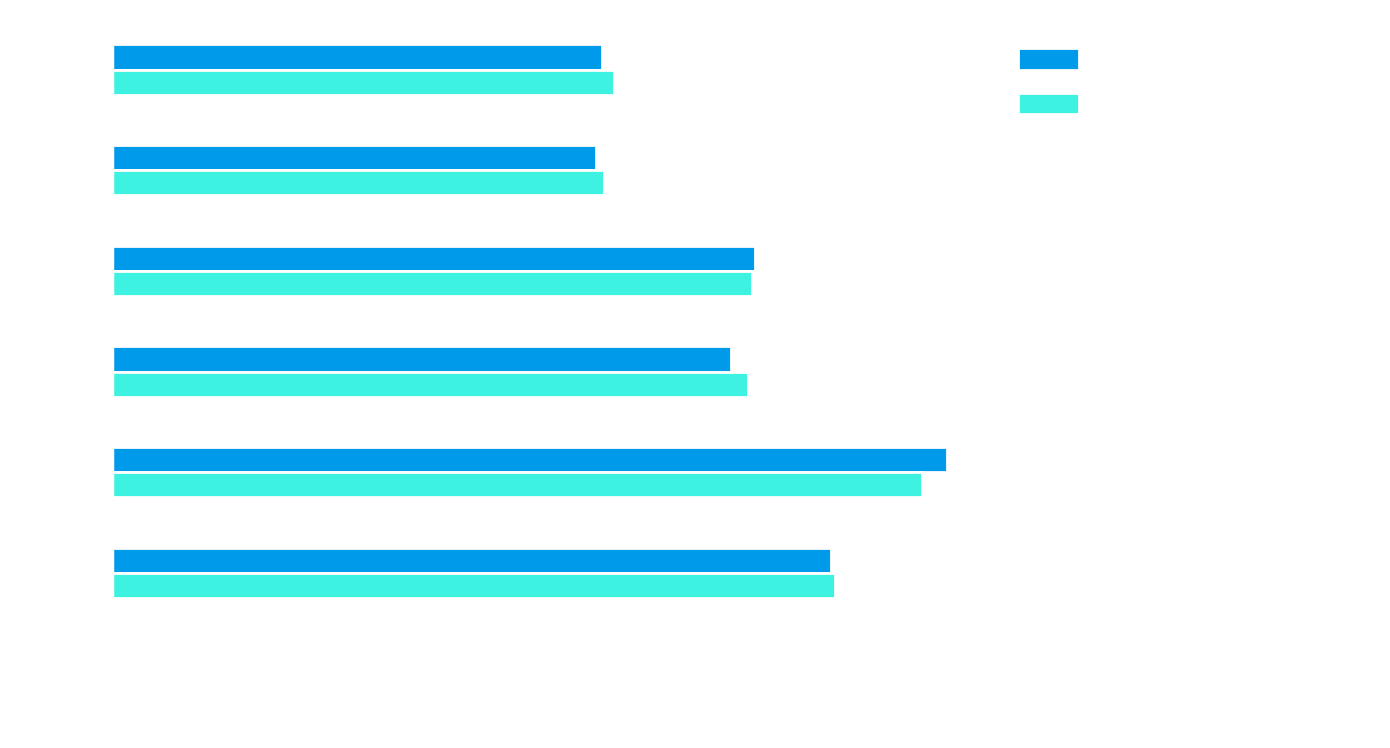

In [155]:
ax = df_efa[["M7 Profit", "Imbalance Profit"]].plot.barh()
ax.set_xlabel("Profit (£/MW)") ### REMOVE
ax.invert_yaxis() ### REMOVE
ax.set_xlim(0, 40); ### REMOVE

To restate: assuming you can sell your DRH power instantly on imbalance or M7, you'd make around £25/MW *every settlement period* when you're in EFAs 3-6, and around £15/MW for EFAs 1 and 2.

If we wanted this to be the profit per EFA block, that's easy enough to do.

In [156]:
(df_efa * 8).round(2)

,M7 Profit,Imbalance Profit
EFA,,
1,126.41,129.51
2,124.95,126.92
3,165.78,165.24
4,159.62,164.15
5,215.41,208.89
6,185.39,186.61


Yes, ironic that I write this simple "Assume 1 EFA = 8 SP" literally the day after London changed timezones. It's close enough.

The summary here is that, even if DRH bid prices flatline down to £0, you're actually going to still be making a profit of at least £15 from selling that energy.

## Extensions

### Seasonality

We all know winter prices can get *crazy*. That might be reflected in the value of our DRH contracts. For simplicity (and given the similarity of profits above), I'll assume we decide to sell on imbalance rather than M7. Don't worry, I reran this after picking M7 and the results don't change.

In [157]:
month = df_shift.index.month.rename("Month")
df_month = df_shift.groupby(["EFA", month]).mean().pipe(get_profit)
df_month = df_month["Imbalance Profit"].unstack()

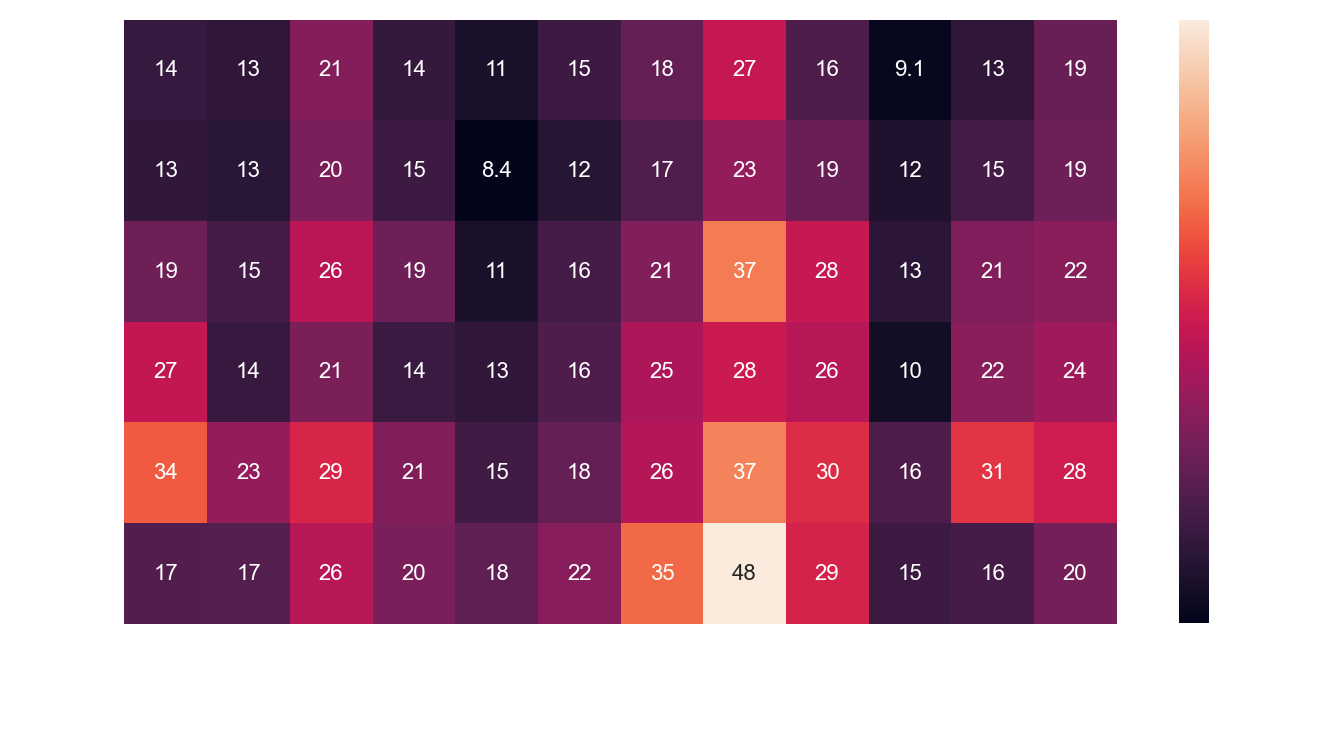

In [158]:
sb.heatmap(df_month, annot=True, cbar_kws=dict(label="Profit (£/MW)"), annot_kws={"size": 8});

That's a crazy outlier in August for EFA 6. Lots of the grid being short and higher imbalance prices.

**Important note:** Recall I pulled the last 12 months of data. That means that after October 30th, the data being used here is from *2021!* I would expect, if we were to rerun this at the end of the year, the November and December profits would look fairly different.

## Perfect Efficiency?

Alright, I'll peel back the curtain and explain how I got my efficiency figure. If we are waiting an hour to discharge, all I have to do is look at the difference in DRH power an hour apart.

To be clear, we are comparing two scenarios. The first (the naive one), is treating DRH charge and imbalance discharge like they happen always in separate SP, so the asset charges, changes state of charge, and then discharges, like a normal buy-sell trade. The second scenario is what actually happens - we continually schedule discharges while, *at the same time* we continually also import energy, and only the net power changes hands.

In [159]:
nominal_efficiency = 0.85 # Pretty standard battery efficiency
actual_powerflow = (df["DRH Power"] - df["DRH Power"].shift(2)).abs()
naive_cycle_powerflow = df["DRH Power"].abs() + df["DRH Power"].shift(2).abs()
fractional_cycle = (actual_powerflow / naive_cycle_powerflow).mean()
effective_efficiency = 1 - (1 - nominal_efficiency) * fractional_cycle
print(f"Starting with {nominal_efficiency=:0.1%}, we calculate an average {effective_efficiency=:0.1%} from {fractional_cycle=:0.3f}")

Starting with nominal_efficiency=85.0%, we calculate an average effective_efficiency=92.5% from fractional_cycle=0.498


I was actually hoping for something above 95%, but hey, effectively increasing your energy efficiency in *any* way is fantastic.

# Summary

The profit from selling DCH energy is volatile. It changes over EFA, and month to month. However, in the vast majority of cases, it sits above £15/MW/SP. EFA 6 represents the greatest value, followed by EFA5. Freely discharging into the most profitable SP of the day is - shockingly - an effective way to make money. 

It is *also* a highly efficiency way to make money and reduce your asset cycling.